In [1]:
from chdrft.config.env import init_jupyter

init_jupyter()
from chdrft.sim.traj import tgo
from chdrft.sim.gz import helper
from chdrft.sim.rb import rb_gen
from chdrft.sim.rb import base as rb_base
from chdrft.sim.rb.base import Vec3, Transform
from chdrft.sim.rb import scenes
import seaborn as sns
import datetime
from gz import sim7, math7

Runnign magic qt5
done
False


/home/benoit/.virtualenvs/env3.10/lib/python3.10/site-packages/pygmo/__init__.py:113: DeprecationWarning: invalid escape sequence '\l'
  """


Registering [gz_sim_components.Environment] = 1433709137331907826
Registering [gz_sim_components.CanonicalLink] = 1899862455720879825
Registering [gz_sim_components.ModelCanonicalLink] = 2958716330662201668
Registering [gz_sim_components.ChildLinkName] = 18008977594029503042
Registering [gz_sim_components.Joint] = 18371370647956686351
Registering [gz_sim_components.Link] = 14769025567331365649
Registering [gz_sim_components.Name] = 17448053894352336366
Registering [gz_sim_components.ParentEntity] = 50322453549405034
Registering [gz_sim_components.ParentLinkName] = 11426747106486107602
Registering [gz_sim_components.Recreate] = 6579594356939739964
Registering [gz_sim_components.World] = 5975074572899138571
Registering [gz_sim_components.WorldSdf] = 18076026013665852038
Registering [gz_sim_components.Actor] = 11808826388832216226
Registering [gz_sim_components.AnimationTime] = 17600374756001327636
Registering [gz_sim_components.AnimationName] = 11035508405656207414
Registering [gz_sim_co

In [8]:
a = tgo.TGOSolver([3,3,3], [
    np.ones(3),
    np.zeros(3),
])
fx = a.func(np.array([-10, 5, 3]), np.array([-5, 7, -8]), 10)

<AxesSubplot: >

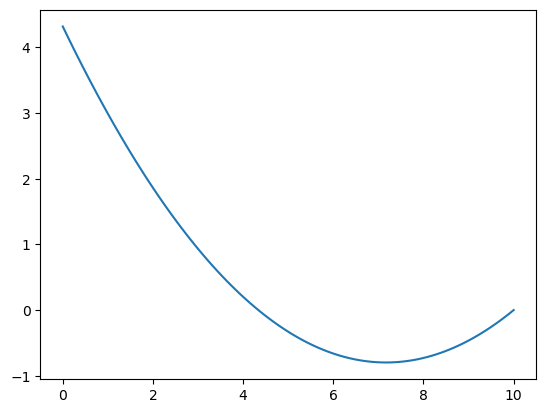

In [13]:
import seaborn as sns
tt = np.linspace(0, 10, 100)
xl = fx(tt)[0]
sns.lineplot(x=tt, y=xl)

<AxesSubplot: >

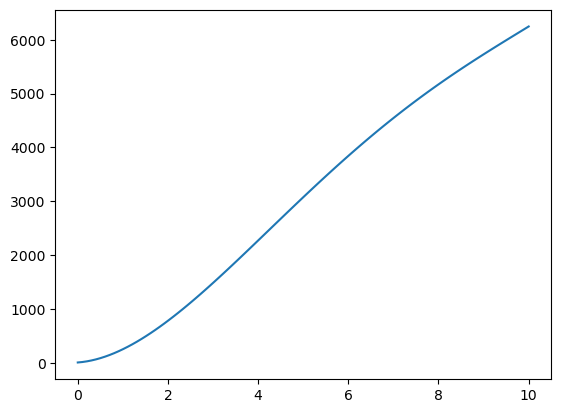

In [15]:
sns.lineplot(x=tt, y=np.cumsum(np.cumsum(xl)))

In [2]:
from astropy import constants as const
from astropy import coordinates
from astropy import units as u


class GravitySpec(cmisc.PatchedModel):
    center: Vec3
    mass: float

    def __call__(self, pos: Vec3) -> Vec3:
        diff = self.center - pos
        const.G.value
        norm = diff.norm
        if norm < 1e-6: return Vec3.Zero()
        k = const.G.value * self.mass / norm**3
        return diff * k


gspec = GravitySpec(center=Vec3.ZeroPt(), mass=const.M_earth.value)

spec = rb_base.SolidSpec.Box(1, 1, 1, 1)

sctx = rb_gen.SceneContext()
tx = rb_gen.RBTree(sctx=sctx)
root = tx.add(
    rb_gen.RBDescEntry(
        data=rb_gen.RBData(base_name='root'),
        spec=spec,
        link_data=rb_gen.LinkData(
            spec=rb_gen.LinkSpec(type=rb_gen.RigidBodyLinkType.FREE, )),
    ))

alt = 300
c0 = coordinates.SphericalRepresentation(lon=0 * u.rad,
                                         lat=0 * u.rad,
                                         distance=(const.R_earth.value + alt) *
                                         u.m)
p0 = c0.to_cartesian().xyz.value
v0 = Vec3(
    coordinates.SphericalDifferential(d_lon=0 * u.rad,
                                      d_lat=1e-4 * u.rad,
                                      d_distance=0 *
                                      u.m).to_cartesian(base=c0).xyz.value)
rbl = tx.create(root, wl=rb_base.Transform.From(pos=p0))
ce = coordinates.SphericalRepresentation(lon=2e-5 * u.rad , lat=0 * u.rad, distance=(const.R_earth.value) * u.m)
pe = rb_base.Vec3(ce.to_cartesian().xyz.value)

sx = tgo.TGOSolver([3,3,3], [pe.vdata])

t_tgo = 100

sx.get(xp=p0, vp=v0.vdata, tgo=t_tgo)

FUU  6378099.99872438
FUU  0.0
FUU  0.0
FUU  127.56199999149587
FUU  0.0
FUU  0.0
FUU  0.0
FUU  0.0
FUU  0.0


array([-0.3600015,, 0.1530744,, -38.2704000,])

In [13]:
import chdrft.dsp.utils as dsp_utils

base = './traj.sdf'
tf = cmisc.tempfile.NamedTemporaryFile()

step = 0.1

with cmisc.tempfile.NamedTemporaryFile() as tf2:
    conv = helper.SDFConverter(base, world_name='scene1')
    conv.fill_with_rbtree()
    conv.write(tf.name)

    runner = helper.GZRunner.Build(tf.name)
    runner.set_physics(step)
    model = runner.model(helper.SDFConverter.MODEL_NAME)
    link = runner.model_link(model)

    runner.set_vel(model, v0)
    t0 = 0

    def conf_cb(*args):
        t = runner.info.sim_time.total_seconds()
        model_tsf = helper.GZDatas.tsf.query(runner, model.entity())
        model_v = helper.GZDatas.l_velocity.query(runner, link.entity())

        gx = gspec(model_tsf.pos_v)
        sim7.GravityCmd.GetOrCreate(runner.ecm,
                                    runner.world.entity()).set_data(gx.to_gz())

        dt= t_tgo-t
        if dt<0: dt=2
        target_acc = Vec3(
            sx.get(xp=model_tsf.pos, vp=model_v.vdata, tgo=dt)) - gx
        target_acc = Vec3(dsp_utils.linearize_clamp(target_acc.vdata, -50, 50, -50, 50))
        runner.set_force(link, target_acc * spec.inertial.mass)

        #sim7.InertialCmd.GetOrCreate(runner.ecm, link.entity()).set_data(a)

    runner.callbacks[helper.GZCallbackMode.PRE].append(conf_cb)

    from chdrft.sim.gz.helper import *
    stats = StatsGatherer(requests=[
        helpers.GZDatas.l_velocity.make_request('link', link.entity()),
        helpers.GZDatas.tsf.make_request('model', model.entity())
    ],
                          iter_downsample=10)
    stats.register(runner)

    #runner.reset()
    runner.server.run(True, 1000, False)
    dfx = pd.DataFrame.from_records(stats.records)
    runner.server.stop()
    runner.fixture.release()
    #del runner

#try_spec(spec)

/tmp/tmpzqldj3kb
[Dbg] [SystemManager.cc:74] Loaded system [gz::sim::systems::SceneBroadcaster] for entity [1]
[Msg] Serving world controls on [/world/scene1/control], [/world/scene1/control/state] and [/world/scene1/playback/control]
[Msg] Serving GUI information on [/world/scene1/gui/info]
[Msg] World [scene1] initialized with [1ms] physics profile.
[Msg] Serving world SDF generation service on [/world/scene1/generate_world_sdf]
[Msg] Serving world names on [/gazebo/worlds]
[Msg] Resource path add service on [/gazebo/resource_paths/add].
[Msg] Resource path get service on [/gazebo/resource_paths/get].
[Msg] Resource path resolve service on [/gazebo/resource_paths/resolve].
[Msg] Resource paths published on [/gazebo/resource_paths].
[Msg] Server control service on [/server_control].
[Msg] Found no publishers on /stats, adding root stats topic
[Msg] Found no publishers on /clock, adding root clock topic
[Dbg] [SimulationRunner.cc:513] Creating PostUpdate worker threads: 3
[Dbg] [Simula

[Err] [Conversions.cc:1722] Tried to convert SDF [world] into [plugin]
release


V([9.4367682, 0.1533749, -38.3098582,])
V([9.4382180, 0.1527584, -38.1942143,])
V([9.4396655, 0.1521429, -38.0787269,])
V([9.4411109, 0.1515284, -37.9633960,])
V([9.4425541, 0.1509148, -37.8482215,])
V([9.4439951, 0.1503021, -37.7332034,])
V([9.4454339, 0.1496903, -37.6183418,])
V([9.4468705, 0.1490795, -37.5036367,])
V([9.4483050, 0.1484696, -37.3890880,])
V([9.4497372, 0.1478607, -37.2746957,])
V([9.4511673, 0.1472527, -37.1604598,])
V([9.4525951, 0.1466456, -37.0463804,])
V([9.4540208, 0.1460395, -36.9324574,])
V([9.4554443, 0.1454343, -36.8186908,])
V([9.4568656, 0.1448300, -36.7050807,])
V([9.4582847, 0.1442267, -36.5916269,])
V([9.4597016, 0.1436243, -36.4783296,])
V([9.4611164, 0.1430228, -36.3651887,])
V([9.4625289, 0.1424223, -36.2522041,])
V([9.4639393, 0.1418227, -36.1393760,])
V([9.4653475, 0.1412241, -36.0267043,])
V([9.4667534, 0.1406264, -35.9141890,])
V([9.4681572, 0.1400296, -35.8018300,])
V([9.4695588, 0.1394338, -35.6896275,])
V([9.4709582, 0.1388389, -35.5775814,])


V([9.7444185, 0.0227234, -13.1271242,])
V([9.7452885, 0.0223545, -13.0528264,])
V([9.7461563, 0.0219866, -12.9786842,])
V([9.7470219, 0.0216195, -12.9046975,])
V([9.7478853, 0.0212534, -12.8308663,])
V([9.7487465, 0.0208883, -12.7571907,])
V([9.7496056, 0.0205240, -12.6836707,])
V([9.7504624, 0.0201607, -12.6103062,])
V([9.7513171, 0.0197983, -12.5370972,])
V([9.7521696, 0.0194369, -12.4640438,])
V([9.7530198, 0.0190764, -12.3911459,])
V([9.7538679, 0.0187168, -12.3184036,])
V([9.7547138, 0.0183581, -12.2458167,])
V([9.7555576, 0.0180004, -12.1733854,])
V([9.7563991, 0.0176436, -12.1011096,])
V([9.7572385, 0.0172877, -12.0289893,])
V([9.7580756, 0.0169328, -11.9570245,])
V([9.7589106, 0.0165788, -11.8852153,])
V([9.7597434, 0.0162257, -11.8135615,])
V([9.7605740, 0.0158736, -11.7420632,])
V([9.7614024, 0.0155224, -11.6707204,])
V([9.7622286, 0.0151721, -11.5995331,])
V([9.7630526, 0.0148228, -11.5285013,])
V([9.7638745, 0.0144744, -11.4576250,])
V([9.7646942, 0.0141269, -11.3869041,])


V([9.8990762, -0.0427703, 1.1994296,])
V([9.8993630, -0.0428914, 1.2323492,])
V([9.8996476, -0.0430116, 1.2651147,])
V([9.8999300, -0.0431308, 1.2977258,])
V([9.9002102, -0.0432491, 1.3301828,])
V([9.9004882, -0.0433665, 1.3624855,])
V([9.9007641, -0.0434830, 1.3946340,])
V([9.9010377, -0.0435985, 1.4266283,])
V([9.9013093, -0.0437132, 1.4584684,])
V([9.9015786, -0.0438269, 1.4901543,])
V([9.9018457, -0.0439397, 1.5216860,])
V([9.9021107, -0.0440515, 1.5530635,])
V([9.9023735, -0.0441624, 1.5842869,])
V([9.9026341, -0.0442724, 1.6153560,])
V([9.9028926, -0.0443815, 1.6462710,])
V([9.9031488, -0.0444897, 1.6770319,])
V([9.9034029, -0.0445969, 1.7076386,])
V([9.9036548, -0.0447032, 1.7380912,])
V([9.9039046, -0.0448086, 1.7683896,])
V([9.9041521, -0.0449131, 1.7985339,])
V([9.9043975, -0.0450166, 1.8285241,])
V([9.9046407, -0.0451193, 1.8583602,])
V([9.9048818, -0.0452210, 1.8880421,])
V([9.9051206, -0.0453217, 1.9175700,])
V([9.9053573, -0.0454216, 1.9469438,])
V([9.9055918, -0.0455205,

V([9.8978275, -0.0420974, 4.5176694,])
V([9.8975317, -0.0419714, 4.5093496,])
V([9.8972339, -0.0418445, 4.5008796,])
V([9.8969339, -0.0417168, 4.4922596,])
V([9.8966318, -0.0415881, 4.4834895,])
V([9.8963276, -0.0414585, 4.4745695,])
V([9.8960213, -0.0413281, 4.4654995,])
V([9.8957128, -0.0411967, 4.4562795,])
V([9.8954023, -0.0410645, 4.4469097,])
V([9.8950896, -0.0409313, 4.4373901,])
V([9.8947748, -0.0407972, 4.4277206,])
V([9.8944579, -0.0406623, 4.4179014,])
V([9.8941388, -0.0405264, 4.4079324,])
V([9.8938177, -0.0403897, 4.3978138,])
V([9.8934945, -0.0402520, 4.3875455,])
V([9.8931691, -0.0401135, 4.3771276,])
V([9.8928416, -0.0399741, 4.3665601,])
V([9.8925120, -0.0398337, 4.3558432,])
V([9.8921803, -0.0396925, 4.3449767,])
V([9.8918465, -0.0395504, 4.3339608,])
V([9.8915106, -0.0394074, 4.3227955,])
V([9.8911726, -0.0392635, 4.3114808,])
V([9.8908324, -0.0391186, 4.3000168,])
V([9.8904902, -0.0389729, 4.2884036,])
V([9.8901458, -0.0388263, 4.2766411,])
V([9.8897994, -0.0386789,

release


In [14]:
dfx['model.pos'] = dfx['model.tsf'].apply(lambda x: x.pos)
dfx[dfx.sim_time <= datetime.timedelta(seconds=t_tgo)]

,sim_time,real_time,iterations,link.vl,model.tsf,model.pos
0,0 days 00:00:00.901000,0 days 00:00:00.037636,10,"V([-0.2848796, 0.1211322, 607.5147699,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378399.871071692, 0.054820942633136985, 497...."
1,0 days 00:00:01.901000,0 days 00:00:00.068375,20,"V([-0.6276330, 0.2668726, 570.6373959,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378399.396503445, 0.2566096675184816, 1084.3..."
2,0 days 00:00:02.901000,0 days 00:00:00.098390,30,"V([-0.9562624, 0.4066074, 534.8889906,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378398.586968124, 0.6008280190000919, 1635.2..."
3,0 days 00:00:03.901000,0 days 00:00:00.128794,40,"V([-1.2709875, 0.5404301, 500.2539703,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378397.4564688895, 1.081521786153273, 2150.9..."
4,0 days 00:00:04.901000,0 days 00:00:00.159268,50,"V([-1.5720279, 0.6684339, 466.7167525,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378396.0187892495, 1.6928301540942021, 2632...."
...,...,...,...,...,...,...
95,0 days 00:01:35.901000,0 days 00:00:02.942428,960,"V([-0.0641545, 0.0272788, -3.2986901,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378100.090673905, 127.52290260447894, 4.7376..."
96,0 days 00:01:36.901000,0 days 00:00:02.972734,970,"V([-0.0386910, 0.0164516, -1.9934658,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378100.041034563, 127.54400949308322, 2.1826..."
97,0 days 00:01:37.901000,0 days 00:00:03.003317,980,"V([-0.0194952, 0.0082895, -1.0059676,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378100.013424964, 127.5557492293216, 0.75895..."
98,0 days 00:01:38.901000,0 days 00:00:03.033545,990,"V([-0.0067198, 0.0028573, -0.3470186,])","data=array([[1.0000000,, 0.0000000,, 0.0000000...","[6378100.001491453, 127.5608234160926, 0.14290..."


<AxesSubplot: xlabel='sim_time', ylabel='model.tsf'>

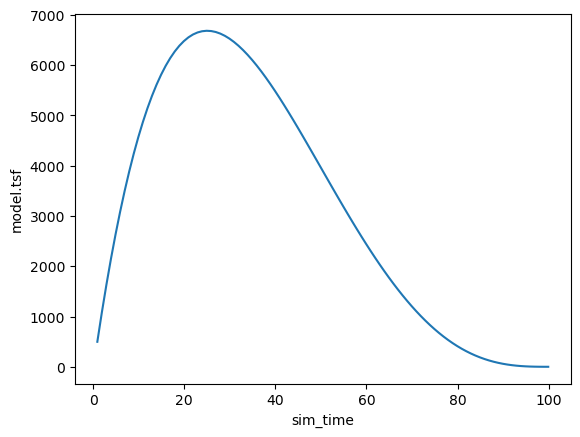

[Msg] Serving graph information on [/world/scene1/scene/graph]
[Msg] Serving full state on [/world/scene1/state]
[Msg] Serving full state (async) on [/world/scene1/state_async]
[Msg] Publishing scene information on [/world/scene1/scene/info]
[Msg] Publishing entity deletions on [/world/scene1/scene/deletion]
[Msg] Publishing state changes on [/world/scene1/state]
[Msg] Publishing pose messages on [/world/scene1/pose/info]
[Msg] Publishing dynamic pose messages on [/world/scene1/dynamic_pose/info]
[Dbg] [SimulationFeatures.cc:72] Simulation timestep set to: 0.1
xxrelease2
[Dbg] [SimulationRunner.cc:540] Exiting postupdate worker thread (0)
Exiting postupdate worker thread (
1)

Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachableException sending a multicast message:Network is unreachable

Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a multicast message:Network is unreachable
Exception sending a mult

In [16]:
xp = dfx['model.tsf'].apply(lambda x: x.pos[0])
yp = dfx['model.tsf'].apply(lambda x: x.pos[1])
zp = dfx['model.tsf'].apply(lambda x: x.pos[2])
t = dfx.iterations
tt = dfx.sim_time.apply(lambda x:x.total_seconds())
sns.lineplot(x=tt, y=zp)

In [ ]:
tgo.